MLB
LAST GAMES UPDATE: 2024-06-17 (9 GAMES)
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
Test Accuracy: 18.04578


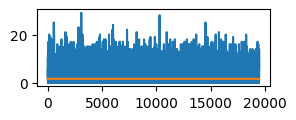

1826/1826 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
   total_pred  spread_pred  total_score_pred             team_x
0      1.6448     0.005638          1.742422  Chicago White Sox
1      1.6448     0.005638          1.742422     Detroit Tigers


,total_pred,team_x
0,1.129074,Chicago White Sox
1,1.129074,Detroit Tigers


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
   total_pred  spread_pred  total_score_pred                team_x
0      1.6448     0.005638          1.742422  San Francisco Giants
1      1.6448     0.005638          1.742422   St. Louis Cardinals


,total_pred,team_x
0,1.129074,San Francisco Giants
1,1.129074,St. Louis Cardinals


KeyboardInterrupt: 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import datetime
from dotenv import load_dotenv
from IPython.display import display
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pytz
import random
import requests
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

pd.set_option('mode.use_inf_as_na', True)
load_dotenv()
API_KEY=os.getenv('ODDS_API_KEY')
SIM = int(999e5)
SPORTS = ['baseball_mlb', 'basketball_nba', 'americanfootball_nfl', 'icehockey_nhl', 'basketball_ncaab', 'americanfootball_ncaaf']

try:
    os.remove('simulations.csv')
except:
    pass

for SPORT in SPORTS:
    simulations = pd.DataFrame(columns=('sport','home_team','away_team','h_score','a_score','time','moneyline_prob'))

    sport = SPORT.split('_')[-1].upper()
    print(sport)

    response = requests.get(f'https://api.the-odds-api.com/v4/sports/{SPORT}/events?apiKey={API_KEY}')
    games = response.json()

    for i, game in enumerate(games):
        df = pd.read_csv(f"./data/{sport.lower()}_games.csv", index_col=0)
        df = df.sort_values('date').reset_index(drop=True)
        del df['index_opp']

        if i == 0:
            last_update = df["date"].iloc[-1]
            num_games = len(df[df["date"] == str(last_update)]) // 2
            print(f'LAST GAMES UPDATE: {last_update} ({num_games} GAMES)')
            
        nulls = pd.isnull(df).sum()
        nulls = nulls[nulls > 100]
        valid_columns = df.columns[~df.columns.isin(nulls.index)]
        df = df[valid_columns].copy()
        df.fillna(value=0, inplace=True)
            
        def add_targets(group):
            group['total_target'] = group['total'].shift(-1)
            group['spread_target'] = group['spread'].shift(-1)
            group['total_score_target'] = group['total_score'].shift(-1)
            return group
            
        df = df.groupby('team', group_keys=False).apply(add_targets)
        df['total_target'][pd.isnull(df['total_target'])] = -0.1
        df['spread_target'][pd.isnull(df['spread_target'])] = -0.1
        df['total_score_target'][pd.isnull(df['total_score_target'])] = -0.1
        df['total_target'] = df['total_target'].astype(float, errors='ignore')
        df['spread_target'] = df['spread_target'].astype(float, errors='ignore')
        df['total_score_target'] = df['total_score_target'].astype(float, errors='ignore')
            
        removed_columns = ['date','team','team_opp','total_target','spread_target','total_score_target']
        selected_columns = df.columns[~df.columns.isin(removed_columns)]

        scaler = MinMaxScaler()
        df[selected_columns] = scaler.fit_transform(df[selected_columns])
        
        def shift_col(team, col_name):
            next_col = team[col_name].shift(-1)
            return next_col
            
        def add_col(df, col_name):
            return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))
            
        df['home_next'] = add_col(df, 'home')
        df['team_opp_next'] = add_col(df, 'team_opp')
        df['date_next'] = add_col(df, 'date')
            
        home_team = game['home_team']
        away_team = game['away_team']
            
        null_indices = df[(df['team'] == home_team) & (df['home_next'].isnull())].index
        for idx in null_indices:
            df.at[idx, 'home_next'] = 1
            df.at[idx, 'team_opp_next'] = away_team
            df.at[idx, 'date_next'] = DATE
        null_indices = df[(df['team'] == away_team) & (df['home_next'].isnull())].index
        for idx in null_indices:
            df.at[idx, 'home_next'] = 0
            df.at[idx, 'team_opp_next'] = home_team
            df.at[idx, 'date_next'] = DATE

        df_rolling2 = df[list(selected_columns) + ['team']]
        df_rolling4 = df[list(selected_columns) + ['team']]
        df_rolling8 = df[list(selected_columns) + ['team']]

        def find_team_averages2(team):
            rolling = team.rolling(2).mean(numeric_only=True)
            return rolling
            
        df_rolling2 = df_rolling2.groupby(['team'], group_keys=False).apply(find_team_averages2)
        rolling_cols2 = [f'{col}_2' for col in df_rolling2.columns]
        df_rolling2.columns = rolling_cols2

        def find_team_averages4(team):
            rolling = team.rolling(4).mean(numeric_only=True)
            return rolling
                
        df_rolling4 = df_rolling4.groupby(['team'], group_keys=False).apply(find_team_averages4)
        rolling_cols4 = [f'{col}_4' for col in df_rolling4.columns]
        df_rolling4.columns = rolling_cols4

        def find_team_averages8(team):
            rolling = team.rolling(8).mean(numeric_only=True)
            return rolling
            
        df_rolling8 = df_rolling8.groupby(['team'], group_keys=False).apply(find_team_averages8)
        rolling_cols8 = [f'{col}_8' for col in df_rolling8.columns]
        df_rolling8.columns = rolling_cols8

        df = pd.concat([df, df_rolling2], axis=1)
        df = pd.concat([df, df_rolling4], axis=1)
        df = pd.concat([df, df_rolling8], axis=1)
        
        if SPORT != 'basketball_ncaab' and SPORT != 'americanfootball_ncaaf':
            df_rolling16 = df[list(selected_columns) + ['team']]
            df_rolling32 = df[list(selected_columns) + ['team']]
            df_matchup = df[list(selected_columns) + ['team','team_opp_next']]

            def find_team_averages16(team):
                rolling = team.rolling(16).mean(numeric_only=True)
                return rolling
                
            df_rolling16 = df_rolling16.groupby(['team'], group_keys=False).apply(find_team_averages16)
            rolling_cols16 = [f'{col}_16' for col in df_rolling16.columns]
            df_rolling16.columns = rolling_cols16
                
            def find_team_averages32(team):
                rolling = team.rolling(32).mean(numeric_only=True)
                return rolling
                
            df_rolling32 = df_rolling32.groupby(['team'], group_keys=False).apply(find_team_averages32)
            rolling_cols32 = [f'{col}_32' for col in df_rolling32.columns]
            df_rolling32.columns = rolling_cols32

            def find_team_matchup(team):
                rolling = team.rolling(2).mean(numeric_only=True)
                return rolling
                
            df_matchup = df_matchup.groupby(['team','team_opp_next'], group_keys=False).apply(find_team_matchup)
            matchup_cols = [f'{col}_matchup' for col in df_matchup.columns]
            df_matchup.columns = matchup_cols
            
            df = pd.concat([df, df_rolling16], axis=1)
            df = pd.concat([df, df_rolling32], axis=1)
            df = pd.concat([df, df_matchup], axis=1)
            
            df = df.dropna() 
                
            full = df.merge(df[rolling_cols2 + rolling_cols4 + rolling_cols8 + rolling_cols16 + rolling_cols32 + matchup_cols +
                            ['team_opp_next','date_next','team']], 
                            left_on=['team','date_next'], 
                            right_on=['team_opp_next','date_next'])
        else:
            df = df.dropna()

            full = df.merge(df[rolling_cols2 + rolling_cols4 + rolling_cols8 +
                            ['team_opp_next','date_next','team']], 
                            left_on=['team','date_next'], 
                            right_on=['team_opp_next','date_next'])
            
        removed_columns = list(full.columns[full.dtypes == 'object']) + removed_columns
        selected_columns = full.columns[~full.columns.isin(removed_columns)]

        if i == 0:
            train_df = full[full['total_target']!=-0.1]
            X = train_df[selected_columns].values
            y_total = train_df['total_target'].values
            y_spread = train_df['spread_target'].values
            y_total_score = train_df['total_score_target'].values

            input_layer = Input(shape=(len(selected_columns),))

            # layer1 = Dense(125, activation='relu')(input_layer)
            # layer2 = Dense(25, activation='relu')(layer1)
            layer3 = Dense(5, activation='relu')(input_layer)

            output_total = Dense(1, name='total_output')(layer3)
            output_spread = Dense(1, name='spread_output')(layer3)
            output_total_score = Dense(1, name='total_score_output')(layer3)
            model = Model(inputs=input_layer, outputs=[output_total, output_spread, output_total_score])
            model.compile(optimizer='adam', loss='mse')

            split = TimeSeriesSplit(n_splits=2)
            early_stopping = EarlyStopping(patience=1)
            for train_index, test_index in split.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train_total, y_test_total = y_total[train_index], y_total[test_index]
                y_train_spread, y_test_spread = y_spread[train_index], y_spread[test_index]
                y_train_total_score, y_test_total_score = y_total_score[train_index], y_total_score[test_index]

                model.fit(X_train,
                        {'total_output': y_train_total, 'spread_output': y_train_spread, 'total_score_output': y_train_total_score},
                        epochs=1,
                        verbose=0,
                        callbacks=[early_stopping],
                        validation_data=(X_test, {'total_output': y_test_total, 'spread_output': y_test_spread, 'total_score_output': y_test_total_score}))
                
            test_df = train_df.iloc[test_index]
            test_predictions = model.predict(test_df[selected_columns])
            y_true = test_df['total_target'].values
            y_pred = test_predictions[0]
            mse = mean_squared_error(y_true, y_pred)
            print(f'Test Accuracy: {mse:.5f}')
            plt.figure(figsize=(3, 1))
            plt.plot(y_true)
            plt.plot(y_pred)
            plt.show()

            model.save('./model.keras')

        model = tf.keras.models.load_model('model.keras')
        predictions = model.predict(full[selected_columns])
        full['total_pred'] = predictions[0]
        full['spread_pred'] = predictions[1]
        full['total_score_pred'] = predictions[2]

        scores = full[full['total_target'] == -0.1].reset_index()
        print(scores[['total_pred','spread_pred','total_score_pred','team_x']])

        if scores['total_pred'].iloc[0] > scores['total_pred'].iloc[1]:
            win = 0
            lose = 1
        else:
            win = 1
            lose = 0
        spread = scores['total_pred'].iloc[win] - scores['total_pred'].iloc[lose]
        total_score = scores['total_pred'].iloc[win] + scores['total_pred'].iloc[lose]

        spread += scores['spread_pred'].iloc[win]
        spread -= scores['spread_pred'].iloc[lose]
        spread /= math.sqrt(3)
        
        total_score += scores['total_score_pred'].iloc[win]
        total_score += scores['total_score_pred'].iloc[lose]
        total_score /= 3
                
        win_mean = (total_score + spread) / 2
        lose_mean = (total_score - spread) / 2 
        if win_mean < 0:
            win_mean = 0
        if lose_mean < 0:
            lose_mean = 0
        scores['total_pred'].iloc[win] = win_mean
        scores['total_pred'].iloc[lose] = lose_mean
        win_team = scores['team_x'].iloc[win]
        lose_team = scores['team_x'].iloc[lose]

        win_scores = np.random.poisson(win_mean, SIM)
        lose_scores = np.random.poisson(lose_mean, SIM)

        moneyline_prob = np.mean(win_scores > lose_scores) + np.mean(
            win_scores == lose_scores) * 0.5

        print(f"SIMULATION: {win_team} {round(moneyline_prob*100,3)}%ML")
        display(scores[['total_pred', 'team_x']])

        time = datetime.strptime(game['commence_time'], '%Y-%m-%dT%H:%M:%S%z')
        eastern = pytz.timezone('US/Eastern')
        eastern_time = time.astimezone(eastern).strftime("%I:%M:%S%p")

        simulations.at[i, 'sport'] = sport

        simulations.at[i, 'home_team'] = home_team
        simulations.at[i, 'away_team'] = away_team
        simulations.at[i, 'time'] = eastern_time

        if scores['team_x'].iloc[win] == home_team:
            simulations.at[i, 'h_score'] = win_mean
            simulations.at[i, 'a_score'] = lose_mean
        else:
            simulations.at[i, 'a_score'] = win_mean
            simulations.at[i, 'h_score'] = lose_mean

    simulations = simulations.sort_values(by=['time', 'home_team']).reset_index(drop=True)
    display(simulations)

    simulations = simulations.dropna()
    if not os.path.isfile('simulations.csv'):
        simulations.to_csv('simulations.csv', index=False)
    else:
        simulations.to_csv('simulations.csv', mode='a', header=False, index=False)
    
os.remove('model.keras')